## Non-parametric Bayes

Non-parametric methods define a probability distribution over an infinite parameter space.
The number of parameters used to describe a data stream is allowed to grow as the data-generating process becomes more complex, and shrink as it becomes simpler.

Contrast non-parametric methods with parametric. 
Parametric methods suppose a finite set of parameters can adequately capture the dynamics of a data-generating process.
The choice of parameters and number needed must be chosen a priori, typically by using a method such as cross-validation. 

In what follows, I'll explore the Dirichlet process (DP). 

## Dirichlet Process

The Dirichlet process is a probability distribution over probability distributions.
In this way, the DP is a flexible distribution capable of modeling may different probability distributions.

A DP needs two parameters: $G$ a base distribution to sample values from, and $\alpha$ a concentration parameter.
When $\alpha$ is large the probability distribution generated by a DP will closely resemble $G$.

The defining characteristic of a DP is what happens when it is sampled a finite number of times.
Any distribution drawn from a DP, chopped into intervals, must follow a Dirichlet **distribution**.

Define a sample distribution from a DP as $X$.
Then on a finite set of intervals $I_{1,2,\cdots,N}$

$$
    [X(I_{1}),X(I_{2}),X(I_{3}),\cdots,X(I_{N}) ] \sim D[\alpha G(I_{1}),\alpha G(I_{2}),\alpha G(I_{3}),\cdots,\alpha G(I_{N}) ] 
$$

where $D$ is a Dirichlet distribution. 
The probabilities, assigned by $X$, inside each interval must follow a Dirichlet distribution.
However, inside that interval the function is allowed to vary. 
The only requirement is that the sum under the function follow the above Dirichlet distribution.

The definition above does not tell us how to actually generate a DP.
Many different methods for generating this infinite distribution have been proposed.
We will focus on one, the Sick-breaking process.

The Stick-breaking process generates a DP by simulating weights according to a Beta distribution, draws samples following the law $G$, and defines a DP as a weighted average.

Draw $K$ samples from a $\mathrm{Beta}(1,\alpha)$ distribution

$$
\pi_{k} \sim \mathrm{Beta}(1,\alpha).
$$
Define the $j$th weight as

$$
w_{j} = \pi_{j}\prod_{i=1^{j-1}} (1-\pi_{i}).
$$

Draw $K$ samples from $G$

$$
    g_{k} \sim G.
$$

Define the probability at $x$ of a $\mathrm{DP}(G,\alpha)$ over $K$ finite draws as

$$
    F(x) = \sum_{i=1}^{\infty} w_{i} \delta_{g_{i}}(x)  
$$

where $\delta_{g_{k}}(x)$ is the dirac delta function, defined

$$
\delta_{g_{i}}(x) = \left\{\begin{array}{cc}
                        1 &x = g_{i}\\
                        0 &\text{otherwise}\\
                    \end{array} \right.
$$

The weights are assigned by sampling from a $\mathrm{Beta}(1,\alpha)$ distribution (Fig. below).

(0, 1)

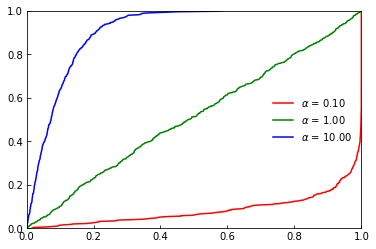

In [118]:
import numpy as np
def cdf(x):
    x,N = sorted(x),len(x)
    return x,np.arange(1.,N+1)/N

fig,ax = plt.subplots()
for (alpha,color) in zip([0.1,1,10],['r','g','b']):
    samples = np.random.beta(1,alpha,500)
    x,px = cdf(samples)
    ax.plot(x,px,color=color,label =r"$\alpha$ = {:0.2f}".format(alpha) )
ax.legend(frameon=False,loc='right')
ax.tick_params(direction='in')
ax.set_ylim(0,1)
ax.set_xlim(0,1)

For small $\alpha$, the distribution will pick values close to $1$.
For large $\alpha$, the distribution picks values closer to $0$.

When $\alpha$ is small, a value close to $1$ will be chosen and the DP will more closely resemble $G$.

In [119]:
def mm2inch(mm):
    return mm/25.4

def cdf(x):
    x,N = sorted(x),len(x)
    return x,np.arange(1.,N+1)/N

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


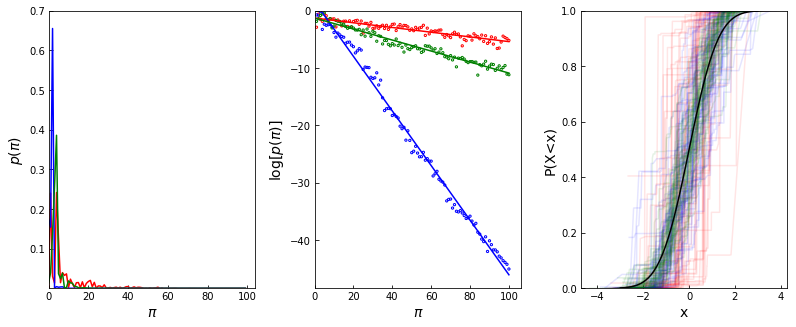

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

def drawFromBeta(alpha):
    return np.random.beta(1,alpha)

def stickBreakConstruct(alpha,N):
    firstPi = drawFromBeta(alpha) 
    pis = [firstPi]
    _1minusPis = 1. - firstPi
    for n in range(N-1):
        newWeight = drawFromBeta(alpha)
        pis.append(newWeight * _1minusPis)
        _1minusPis = _1minusPis*(1.-newWeight)
    return pis

def sampleFromGdist(N,mu,sigma):
    return list(np.random.normal(mu,sigma,N))

weights_Alpha1  = stickBreakConstruct(1,100)
weights_Alpha10 = stickBreakConstruct(5,100)
weights_Alpha01 = stickBreakConstruct(10,100)

thetas = sampleFromGdist(100,0,1)

fig,axs = plt.subplots(1,3)
ax = axs[0]
ax.plot(weights_Alpha01,'r-')
ax.plot(weights_Alpha1,'b-')
ax.plot(weights_Alpha10,'g-')

ax.tick_params(direction='in')
ax.set_xlim(0,ax.get_xlim()[-1])
ax.set_ylim(0,ax.get_ylim()[-1])
ax.set_yticks(ax.get_yticks()[1:])

ax.set_xlabel(r'$\pi$',fontsize=14)
ax.set_ylabel(r'$p(\pi)$',fontsize=14)

ax = axs[1]
N       = np.arange(1,100+1)

weights = np.log10(weights_Alpha01)
ax.scatter(N,weights,s=5,edgecolor='r',facecolor='None')
b1,b0 = np.polyfit(N,weights,1)
ax.plot(N,b0+b1*N,'r-')

weights = np.log10(weights_Alpha1)
ax.scatter(N,weights,s=5,edgecolor='b',facecolor='None')
b1,b0 = np.polyfit(N,weights,1)
ax.plot(N,b0+b1*N,'b-')

weights = np.log10(weights_Alpha10)
ax.scatter(N,weights,s=5,edgecolor='g',facecolor='None')
b1,b0 = np.polyfit(N,weights,1)
ax.plot(N,b0+b1*N,'g-')

ax.tick_params(direction='in')
ax.set_xlim(0,ax.get_xlim()[-1])
ax.set_ylim(ax.get_ylim()[0],0)

ax.set_xlabel(r'$\pi$',fontsize=14)
ax.set_ylabel(r'$\log[p(\pi)]$',fontsize=14)

def generateDP(N, alpha,Gparams):
    weights = stickBreakConstruct(alpha,N)
    
    mu,sigma = Gparams
    thetas = sampleFromGdist(N,mu,sigma)
    
    DPdistribution = []
    for (weight,theta) in zip(weights,thetas):
        DPdistribution.append((theta,weight))
    DPdistribution = sorted(DPdistribution)
    return DPdistribution

N = 200
Iters = 50
Gparams = [0,1]

ax = axs[2]
for (alpha,color) in zip([1,5,10],['r','b','g']):   
    for iterations in range(Iters):
        DPdistribution = generateDP(N,alpha,Gparams)
        values,probs = zip(*DPdistribution)
        cuumProbs = np.cumsum(probs)
        ax.plot(values,cuumProbs,color=color,alpha=0.1)
    
xs = np.linspace(-3,3)
standardNormalCDF = scipy.stats.norm(0,1).cdf(xs)
ax.plot(xs,standardNormalCDF,'k-')

ax.tick_params(direction='in')
ax.set_ylim(0,1)
ax.set_xlabel('x',fontsize=14)
ax.set_ylabel('P(X<x)',fontsize=14)

fig.set_size_inches(1.5*mm2inch(189),mm2inch(189)/1.6)
fig.set_tight_layout(True)